In [ ]:
#for online, identify the patterns of attribution. timing of attributions
#phone separate those who did and didn't receive a call

#funnel analysis
#flow diagram

In [ ]:
###questions###
#how to prevent forknowledge. For example, policy quote inversely related to esign

#what drives phone activity. customer initiated?
#Metromile initiated. all customers who provided a number, but haven't signed up are called. no lead scoring

#what does direct, organic, internal mean
    #direct - website typed in
    #organic - search engine
    #internal - app users?
#any information on monthly revenue from insurance policies. margins by insurance product?

#metromile vehicles insured compared to industry norm

In [580]:
from __future__ import division
import pandas as pd
import numpy as np
import time
import pylab as plt
from scipy import stats
import time
import xgboost as xgb
import sys
import sklearn
#sys.path.append('xgboost/wrapper/')
import datetime
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Normalizer
%matplotlib inline

In [1051]:
#original metromile tables
attribution = pd.read_csv('attribution.csv')
converted = pd.read_csv('converted.csv')
drivers = pd.read_csv('drivers.csv')
phone = pd.read_csv('phone.csv')
policies = pd.read_csv('policies.csv')
vehicles = pd.read_csv('vehicles.csv')

phone_experiment = pd.read_csv('phone_experiment.csv')
phone_experiment = phone_experiment.rename(columns={"AccountNo": "account_number"})
phone_experiment = phone_experiment.drop_duplicates()
phone_experiment = phone_experiment.set_index('account_number')

#additional datasets
#http://federalgovernmentzipcodes.us/
zipcode = pd.read_csv('zipcode-database.csv')
#http://blog.splitwise.com/2014/01/06/free-us-population-density-and-unemployment-rate-by-zip-code/
zipcode_unempl = pd.read_csv('Unemployment+Unsorted.csv')
zipcode_density = pd.read_csv('Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv')

In [3]:
sources = ['attribution', 'converted','drivers','phone','policies','vehicles','zipcode','zipcode_unempl','zipcode_density']
for source in sources:
    print "name: {}     shape: {}".format(source, eval(source).shape)

name: attribution     shape: (386877, 6)
name: converted     shape: (7791, 2)
name: drivers     shape: (61049, 12)
name: phone     shape: (26848, 3)
name: policies     shape: (42946, 15)
name: vehicles     shape: (51534, 10)
name: zipcode     shape: (81831, 20)
name: zipcode_unempl     shape: (33120, 3)
name: zipcode_density     shape: (33144, 4)


In [735]:
attrib_source = attribution.groupby('mm_category').account_number.agg(['count','nunique']).sort('nunique', ascending=False)
attrib_source['attrib_per_unique_account'] = attrib_source['count'] / attrib_source['nunique']
attrib_source.head(15)

,count,nunique,attrib_per_unique_account
mm_category,,,
organic,163959,25335,6.471640
direct,171454,24200,7.084876
Internal,10925,7365,1.483367
facebook,7713,6913,1.115724
Google Display,9164,6593,1.389959
brate,3897,3729,1.045052
Google Search - Brand,3636,2785,1.305566
comparenow,2533,2427,1.043675
Google Search - Non Brand,2411,2282,1.056529


In [5]:
#387k rows, 55k unique accounts
#unique account stats: 55k total, 25k organic, 24k direct, 7k internal, 7k facebook, 6.6k google display
#2 months from August 1st to Oct 3rd
#171k direct, 1604k organic
#organic is from a web search, direct is from someone directly typing in the address
#organic and direct categorization is not very accurate. Groupon ran de-indexed from google for 6 hours and
attribution.head(3)

,account_number,mm_category,source,medium,campaign,weblog_ts
0,33-022044,facebook,facebook,cpc,facebook_desktop,2015-09-02 23:33:33
1,31-119795,organic,NaN,NaN,NaN,2015-08-18 03:47:38
2,33-020459,organic,NaN,NaN,NaN,2015-08-18 00:30:12


In [6]:
#attribution data from Aug-2015 to Oct-2015
print "years covered by attribution data"
print attribution['weblog_ts'].str[0:4].unique()
#months in attribution
print 'Months covered by attribution data'
print attribution['weblog_ts'].str[5:7].unique()

years covered by attribution data
['2015']
Months covered by attribution data
['09' '08' '10']


In [7]:
#check how many conversions have no attributions
merged = attribution.merge(converted, how='outer')
merged[pd.notnull(merged['esign_datetime']) & pd.isnull(merged['mm_category'])].shape

(539, 7)

In [8]:
#7791 conversions, all unique
# 2 months, Aug 1 to Oct 7
#how much does attribution overlap with conversion tables? 539 conversions have no attribution activity
converted.head(3)

,account_number,esign_datetime
0,31-121474,2015-08-31 21:14:40
1,33-009611,2015-08-26 20:47:49
2,31-124797,2015-09-09 18:22:36


In [9]:
drivers.head(2)

,account_number,driver_id,primary_address_postalcode,birthdate,marital_status,sex,driver_type,education_code,age_licensed,occupation_code,residence_status,total_points
0,02-000006,ad11d676-353a-d785-fd97-55c94409c01d,15005,1989-01-02,S,M,Primary,4,16,10002,Neither,0
1,02-000007,bed61b91-9419-0756-710a-55c9462e05d4,15005,1989-01-02,S,M,Primary,4,16,10002,Neither,0


In [10]:
len(set(merged['account_number']).intersection(set(drivers['account_number'])))

39292

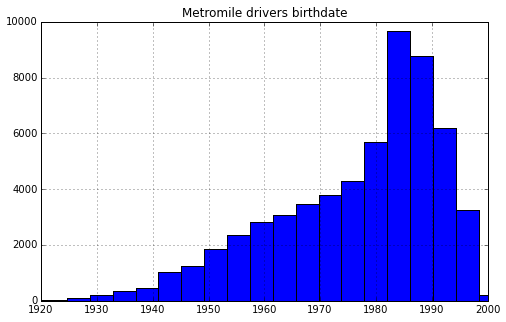

In [11]:
#61k drivers, 39k of which overlap with attributions or conversion
drivers['birthdate'].str[:4].astype(float).hist(bins=40,figsize=(8,5))
plt.xlim([1920,2000])
plt.title('Metromile drivers birthdate')

In [12]:
phone.head(5)

,call_time,call_result,account_number
0,9/4/15 10:41,No Answer,31-123113
1,9/4/15 14:37,Left Voicemail,31-123113
2,9/8/15 14:09,NaN,31-123113
3,9/23/15 15:32,No Answer,31-123113
4,9/30/15 8:58,No Answer,31-123113


In [13]:
phone_experiment.head()

,account_number,Cell,Imported,ImportedDate
0,02-000020,Modeled,No,NaN
2,02-000022,Modeled,No,NaN
4,02-000023,Modeled,No,NaN
6,02-000024,Modeled,Yes,8/26/15
7,02-000028,Modeled,Yes,8/26/15


In [15]:
#phone log is from the last two months
month = []
for row in phone['call_time'].apply(lambda x: x.split('/')):
    month.append(row[0])
    
#month from phone log
from collections import Counter
Counter(month)

Counter({'10': 2052, '9': 24796})

In [16]:
#42946 policies, 42901 unique
#35,886 listed as converted
#pd.isnull(policies.merge(converted, how='left')['esign_datetime']).sum()
policies.head(3)

,account_number,product_state,policy_date_entered,current_td_program_name,has_tnc,policy_feature_group,product_enum,credit_score,prior_insurance,prior_bi_limit,prior_insurance_company,prior_insurance_premium,prior_ins_length_of_time,prior_liability_c,quote_status
0,31-134771,CA,2015-10-06 16:03:10,3,n,3301,CA02,0,C,Greater than minimum but < 50/100,NaN,0,0,0,completed
1,31-120912,CA,2015-08-30 00:59:11,3,n,3301,CA02,0,C,Greater than minimum but < 50/100,NaN,0,0,0,completed
2,31-113782,CA,2015-08-12 05:08:58,3,n,3301,CA02,0,C,Greater than minimum but < 50/100,NaN,0,0,0,completed


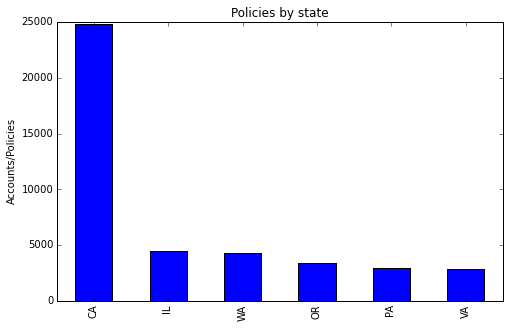

In [17]:
policies_bystate = policies['product_state'].value_counts()

plt.figure(figsize=(8,5))
policies_bystate.plot(kind='bar')
#plt.bar(policies_bystate.index, data=policies_bystate.values)
plt.title('Policies by state')
plt.ylabel('Accounts/Policies')

In [18]:
#more recent cars. mostly 2005-2015
#~90% of accounts are single car
#most popular brands Toyota (8k), honda (6k), ford (5k), Chevrolet (4)kla
vehicles.head()

,account_number,vehicle_id_c,make,model,year,ownership_type,loan_lending_company,current_total_daily_base,current_total_per_mile,reported_prior_yearly_mileage
0,02-000006,102000001,Chevrolet,Blazer,2003,Paid for,NaN,1.04,0.049,NaN
1,02-000007,102000002,Chevrolet,Blazer,2003,Paid for,NaN,1.04,0.049,NaN
2,02-000008,102000003,Chevrolet,Blazer,2003,Paid for,NaN,1.04,0.049,NaN
3,02-000009,102000004,Chevrolet,Blazer,2003,Paid for,NaN,1.04,0.049,NaN
4,02-000010,102000005,Chevrolet,Blazer,2003,Paid for,NaN,1.04,0.049,NaN


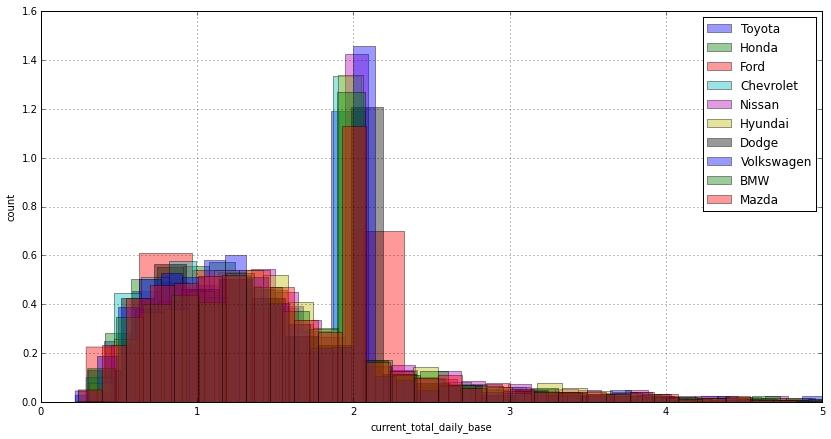

In [19]:
#playing around and charting vehicle data
variable = 'make'
xvar = 'current_total_daily_base'

top_10 = vehicles.groupby(variable).count().sort('account_number', ascending=False).index[0:10]

plt.figure(figsize=(14,7))
plt.xlim([0,5])
plt.xlabel(xvar)
plt.ylabel('count')

for item in list(top_10):
    vehicles[vehicles[variable] == item][xvar].hist(alpha=.4, label=str(item), bins=50, normed=True)
plt.legend()

In [20]:
top_10

Index([u'Toyota', u'Honda', u'Ford', u'Chevrolet', u'Nissan', u'Hyundai',
       u'Dodge', u'Volkswagen', u'BMW', u'Mazda'],
      dtype='object', name=u'make')

In [21]:
ve = vehicles.groupby(['make','model','year']).agg(['mean','median','count'])
ve.loc['Chevrolet','Volt'];

In [22]:
### End Exploratory Analysis ###

### Begin Summary Statistics ###

In [23]:
"""
summary = attrib_converted.pivot_table(values='account_number', index='mm_category', columns='esign_bool', aggfunc='count')
summary.columns = ['False','True']
summary['Total'] = summary.sum(1)
summary['Conversion'] = summary['True'] / summary['Total']

summary = summary.sort('Total', ascending=False)
"""

"\nsummary = attrib_converted.pivot_table(values='account_number', index='mm_category', columns='esign_bool', aggfunc='count')\nsummary.columns = ['False','True']\nsummary['Total'] = summary.sum(1)\nsummary['Conversion'] = summary['True'] / summary['Total']\n\nsummary = summary.sort('Total', ascending=False)\n"

In [24]:
### End Summary Statistics ###

### Begin Prediction ###

In [191]:
np.argsort([1,2,3,4,5,6,7,8,9,10,11])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [342]:
def score(true, predict):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
    print "F1 Score: {}".format(round(f1_score(true, predict),4))
    print "accuracy: {}".format(round(accuracy_score(true, predict),4))
    print "precision: {}".format(round(precision_score(true, predict),4))
    print "recall: {}".format(round(recall_score(true, predict),4))
    print "confusion matrix:"
    print  confusion_matrix(true, predict)

def model_eval(xTr,yTr,xTe, yTe, model):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
    model.fit(xTr, yTr)
    
    predict = model.predict(xTe)
    predict_prob = model.predict_proba(xTe)[:,1]
    top_decile_cutoff = int(len(xTe) * 0.9)
    top_decile_esign = np.mean(yTe[np.argsort(predict_prob)][top_decile_cutoff:])
    esign = np.mean(yTe)
    
    print "top decile esign rate: {}".format(round(top_decile_esign, 4))
    print "average esign rate: {}".format(round(esign,4))
    print "top decile esign / avg. esign: {}".format(round(top_decile_esign / esign,4))
    print ""                                      
    print "F1 Score: {}".format(round(f1_score(yTe, predict),4))
    print "accuracy: {}".format(round(accuracy_score(yTe, predict),4))
    print "precision: {}".format(round(precision_score(yTe, predict),4))
    print "recall: {}".format(round(recall_score(yTe, predict),4))
    print "confusion matrix:"
    print  confusion_matrix(yTe, predict)
    
    roc = sklearn.metrics.roc_curve(yTe, predict_prob)
    auc = sklearn.metrics.roc_auc_score(yTe, predict_prob)
    
    plt.figure(figsize=(6, 4))
    plt.plot(roc[0],roc[1])
    plt.plot(np.linspace(0,1,101),np.linspace(0,1,101), '--',c='k')
    plt.title('ROC Curve, AUC: {}'.format(round(auc,3)))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

In [1143]:
zipcode.shape

(81831, 20)

In [1142]:
for i in zipcode_columns:
    print i

Zipcode
State
EstimatedPopulation
TaxReturnsFiled
TotalWages
2010 Population
Land-Sq-Mi
Density Per Sq Mile
Unemp. Rate


In [26]:
#filter out secondary drivers. Each account is represented by the data from the primary driver
primary_drivers = drivers[drivers['driver_type']=='Primary']

#filtered by primary drivers, then chose the first field
drivers_out = primary_drivers.groupby('account_number').first()

#merge zipcode sources, before merging with drivers data
zipcode = pd.read_csv('zipcode-database.csv')
zipcode = zipcode.merge(zipcode_unempl, left_on='Zipcode',right_on='Zip',how='left')
zipcode = zipcode.merge(zipcode_density, left_on='Zipcode', right_on='Zip/ZCTA', how='left')
zipcode['Unemp. Rate'] = zipcode['Unemp. Rate'].str[:-1].astype(float)

#drop columns
drivers_drop = ['driver_id','driver_type']

#set as copy to avoid chain indexing
drivers_out2 = drivers_out.copy().reset_index()

#merge with an external zipcode to state
zipcode_columns = ['Zipcode','State','EstimatedPopulation','TaxReturnsFiled','TotalWages','2010 Population','Land-Sq-Mi','Density Per Sq Mile','Unemp. Rate']
drivers_out2 = pd.merge(left=drivers_out2, right=zipcode[zipcode_columns].drop_duplicates(), left_on='primary_address_postalcode', right_on='Zipcode', how='left')

#converting to an age
drivers_out2['birthyear'] = drivers_out2['birthdate'].str[:4].astype(float)
drivers_out2['age'] = 2015 - drivers_out2['birthyear']

#zipcodes with the first two digits should be similar geographically
drivers_out2['Zipcode_agg'] = np.round(zipcode['Zipcode'],-3)

#per capita stats
drivers_out2['AvgWages'] = drivers_out2['TotalWages'] / drivers_out2['EstimatedPopulation']
drivers_out2['AvgTaxReturnsFiled'] = drivers_out2['TaxReturnsFiled'] / drivers_out2['EstimatedPopulation']

#label encoder
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()

drivers_label = ['sex', 'residence_status']
for field in drivers_label:
    drivers_out2[field] = lbl.fit_transform(drivers_out2[field])

#one hot encoding
drivers_dummies = ['marital_status','State']
for field in drivers_dummies:
    temp = pd.get_dummies(drivers_out2[field], prefix=field, dummy_na=True)
    drivers_out2[temp.columns] = temp

drivers_drop = ['birthdate','driver_id','driver_type']
drivers_out3 = drivers_out2.drop(drivers_dummies + drivers_drop,1)
drivers_out3 = drivers_out3.set_index('account_number')

In [1117]:
#prepare phone data
phone_out = phone.copy()
call_result_dummies = pd.get_dummies(phone_out['call_result'])
phone_out[call_result_dummies.columns] = pd.get_dummies(phone['call_result'])

success_contact = np.array(['Contact','Correct Contact','Transfer'])
phone_out['agg_call_success'] = phone_out['call_result'].isin(success_contact) * 2 - 1
phone_out2 = phone_out.merge(drivers_out2[['account_number','State']],how='left')

time_zone_adjust = {'CA':0,'PA':3,'WA':0,'IL':2,'OR':0,'VA':3, 'NaN':0}
phone_out2['time_zone_adjust'] = phone_out2['State'].map(time_zone_adjust.get)

phone_out2['call_time'] = pd.to_datetime(phone_out2['call_time'])
phone_out2['call_month'] = phone_out2['call_time'].dt.month
phone_out2['call_day'] = phone_out2['call_time'].dt.day
phone_out2['call_hour'] = phone_out2['call_time'].dt.hour
phone_out2['call_hour_local'] = phone_out2['call_hour'] + phone_out2['time_zone_adjust']
phone_out2['call_minute'] = phone_out2['call_time'].dt.minute

#want to incorporate time of day data

phone_out3 = phone_out.groupby('account_number').sum()

#phone_out4 excludes data after initial call
phone_out4 = phone_out2.sort('call_time').groupby('account_number').first()
phone_drop = ['call_time','call_result', 'State']
phone_out4 = phone_out4.drop(phone_drop,1)

#phone_out5 additionally excludes the result of the initial call
initial_phone_drop = ['Bad Number', u'Busy', u'Contact', u'Correct Contact',
       u'Left Live Message', u'Left Voicemail', u'No Answer', u'Set Callback',
       u'Transfer', u'Wrong Number', u'agg_call_success', u'time_zone_adjust']
phone_out5 = phone_out4.drop(initial_phone_drop,1)

In [28]:
policies_out = policies.groupby('account_number').first()

#drop quote status. probably indicates whether someone has already signed up
policies_drop = ['policy_date_entered','quote_status']
policies_out2 = policies_out.drop(policies_drop,1)

#100+ different insurance companies. simply encoding T/F 
policies_out2['prior_insurance_company'] = policies_out2['prior_insurance_company'].notnull()

#encode ordinal features
policies_label = ['has_tnc']
for field in policies_label:
    policies_out2[field] = lbl.fit_transform(policies_out2[field])

#one hot encoding
policies_dummies = ['product_state','product_enum','prior_insurance','prior_bi_limit']

for field in policies_dummies:
    one_hot = pd.get_dummies(policies_out2[field], prefix=field,dummy_na=True)
    policies_out2[one_hot.columns] = one_hot
    
policies_out3 = policies_out2.drop(policies_dummies, 1)

In [445]:
vehicles_out = vehicles.groupby('account_number').first()

#drop current daily base, variable, and prior year mileage. i don't think these are knowable at point of first call
vehicles_drop = ['vehicle_id_c','loan_lending_company','reported_prior_yearly_mileage', 'current_total_daily_base','current_total_per_mile']
vehicles_out2 = vehicles_out.drop(vehicles_drop,1)

#group uncommon makes and models as "other"
top_makes = vehicles_out2['make'].value_counts().index[:20]
vehicles_out2['make'].ix[~vehicles_out2['make'].isin(top_makes)] = "Other"

top_models = vehicles_out2['model'].value_counts().index[:50]
vehicles_out2['model'].ix[~vehicles_out2['model'].isin(top_models)] = "Other"

#encode ordinal features
policies_label = []
for field in policies_label:
    vehicles_out2[field] = lbl.fit_transform(vehicles_out2[field])

#one hot encoding
vehicles_dummies = ['make','model','ownership_type']

for field in vehicles_dummies:
    one_hot = pd.get_dummies(vehicles_out2[field], prefix=field)
    vehicles_out2[one_hot.columns] = one_hot
    
vehicles_out3 = vehicles_out2.drop(vehicles_dummies, 1)

In [29]:
#removing attribution activity occuring after signup
attr_conv = attribution.merge(converted, left_on='account_number', right_on='account_number', how='left')
attr_conv['weblog_ts'] = pd.to_datetime(attr_conv['weblog_ts']) 
attr_conv['esign_datetime'] = pd.to_datetime(attr_conv['esign_datetime']) 
attr_conv['mask'] = ~((attr_conv['weblog_ts'] - attr_conv['esign_datetime']) > 0)

#filtering attribution activity occuring after first call
phone_grouped = phone.groupby('account_number').min().reset_index()
attr_phone = attribution.merge(phone_grouped, left_on='account_number', right_on='account_number', how='left')
attr_phone['weblog_ts'] = pd.to_datetime(attr_phone['weblog_ts']) 
attr_phone['call_time'] = pd.to_datetime(attr_phone['call_time']) 
attr_phone['mask'] = ~((attr_phone['weblog_ts'] - attr_phone['call_time']) > 0)

print 'original attributions'
print attribution.shape[0]

#filtering based on signup was causing leakage
"""print 'attributions, filtered if after signup date'
esign_filtered_attr = attribution.ix[attr_conv['mask']]
print esign_filtered_attr.shape[0]
print '{0:.4f} % change'.format((esign_filtered_attr.shape[0]- attribution.shape[0]) / attribution.shape[0])
print ''
"""

print 'attributions, filtered if after initial phone call'
initialphone_filtered_attr = attribution.ix[attr_phone['mask']]
print initialphone_filtered_attr.shape[0]
print '{0:.4f} % change'.format((initialphone_filtered_attr.shape[0]- attribution.shape[0]) / attribution.shape[0])
print ''

print 'original unique accounts'
original_uacct = attr_conv['account_number'].unique()
print original_uacct.shape[0]
"""
print 'unique accounts, filtered after esign'
esign_filtered_uacct = esign_filtered_attr['account_number'].unique()
print esign_filtered_uacct.shape[0]
print '{0:.4f} % change'.format((esign_filtered_uacct.shape[0]- original_uacct.shape[0]) / original_uacct.shape[0])
"""

print 'unique accounts, filtered after initial phone call'
initialphone_filtered_uacct = initialphone_filtered_attr['account_number'].unique()
print initialphone_filtered_uacct.shape[0]
print '{0:.4f} % change'.format((initialphone_filtered_uacct.shape[0]- original_uacct.shape[0]) / original_uacct.shape[0])

original attributions
386877
attributions, filtered if after initial phone call
321109
-0.1700 % change

original unique accounts
54949
unique accounts, filtered after initial phone call
54770
-0.0033 % change


In [30]:
#bucket small categories to "other"
top_n = 10
attribution1 = initialphone_filtered_attr.copy()
mm_category_indicator = attribution1['mm_category'].value_counts().index[:top_n]
source_indicator = attribution1['source'].value_counts().index[0:top_n]
medium_indicator= ['cpc','email']
campaign_indicator = attribution1['campaign'].value_counts().index[0:top_n]

#convert categorical to dummy variables
attribution2 = attribution1.copy()
attrib_todummy = ['mm_category','source','medium','campaign']
#column name label abbreviations
attrib_todummy_short = ['mm','src','medm','cmpgn']

for idx, col in enumerate(attrib_todummy):
    attribution2[col][~attribution1[col].isin(eval(col + "_indicator"))] = (col + "_other")
    dummies = pd.get_dummies(attribution2[col])
    dummies_columns = attrib_todummy_short[idx] + '_' + dummies.columns
    attribution2[dummies_columns] = dummies
attribution2 = attribution2.drop(attrib_todummy,1)
    
#creating a column of 1's
attribution2['attribution_count'] = 1

#converting datetime to date
attribution2['weblog_date'] = pd.to_datetime(attribution2['weblog_ts']).dt.date

#grouping to 1 attribution per day max
attribution3 = attribution2.groupby('account_number').sum()
attribution4 = attribution2.groupby(['account_number','weblog_date']).first()
attribution4 = attribution4.reset_index().groupby('account_number').sum()
attribution4.columns = [col + '_enc' for col in attribution4.columns]

#grouping activity to one per day doesn't appear to improve prediction
#grouping from attribution to account level
attribution5 = attribution3.join(attribution4)


/Users/aerie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [436]:
converted_out = converted.copy()
converted_out = converted_out.set_index('account_number')

In [911]:
#unique accounts with attribution activity
out1 = attribution5.join(converted_out, how = 'left')
out1['esign_boolean'] = pd.notnull(out1['esign_datetime'])*1
out2 = out1.join(drivers_out3, how='left')
out3 = out2.join(policies_out3 , how='left')
out4 = out3.join(vehicles_out3, how='left')
out5 = out4.join(phone_out5, how='left')

#data preparation
y = out5['esign_boolean']
X = out5.drop(['esign_datetime', 'esign_boolean'],1)

#modify incompatible characters for xgboost
col_modified = []
for col in X.columns:
    col_modified.append(col.replace("<","less than").replace(">","greater than"))
X.columns = col_modified    

#fill NaN with averages, rounded down
for col in X.columns:
    X[col] = X[col].fillna(round(np.mean(X[col]),0))
    
    
#remove features with zero variation
nm = Normalizer()
zero_var_columns = X.columns[nm.fit_transform(X).var(0) == 0]
X = X.drop(zero_var_columns, 1)

print out1.shape
print out2.shape
print out3.shape
print out4.shape
print out5.shape

#separate training & cross-validation with test
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
X_excl_attribution = X.drop(list(attribution5.columns & X.columns),1)
X_exclAttr_train, X_exclAttr_test, y_exclAttr_train, y_exclAttr_test = train_test_split(X_excl_attribution,y)

X_excl_phone = X.drop(list(phone_out4.columns & X.columns),1)
X_exclPhone_train, X_exclPhone_test, y_exclPhone_train, y_exclPhone_test = train_test_split(X_excl_phone,y)

(54770, 76)
(54770, 109)
(54770, 142)
(54770, 216)
(54770, 221)


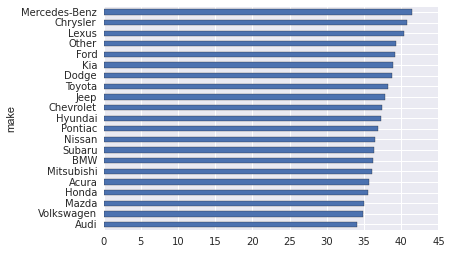

In [912]:
temp = drivers_out2.set_index('account_number').join(policies.set_index('account_number'))
temp = temp.join(vehicles_out)
output = temp.groupby('make').mean()['age']
output.sort(inplace=False).plot(kind='barh')

In [1217]:
#unique accounts with phone activity
out1 = phone_out4.join(converted_out, how = 'left')
out1['esign_boolean'] = pd.notnull(out1['esign_datetime'])*1
out2 = out1.join(drivers_out3, how='left')
out3 = out2.join(policies_out3 , how='left')
out4 = out3.join(vehicles_out3 , how='left')
out5 = out4.join(attribution3, how='left')

#data preparation
y = out5['esign_boolean']
X = out5.drop(['esign_datetime', 'esign_boolean'],1)

#modify incompatible characters for xgboost
col_modified = []
for col in X.columns:
    col_modified.append(col.replace("<","less than").replace(">","greater than"))
X.columns = col_modified    

#logistic regression can't handle NaN. fill with averages, rounded down
for col in X.columns:
    X[col] = X[col].fillna(round(np.mean(X[col]),0))
    
#remove features with zero variation
nm = Normalizer()
zero_var_columns = X.columns[nm.fit_transform(X).var(0) == 0]
X = X.drop(zero_var_columns, 1)

print out1.shape
print out2.shape
print out3.shape
print out4.shape
print out5.shape

#separate training & cross-validation with test
Xtrain_phone, Xtest_phone, ytrain_phone, ytest_phone = train_test_split(X,y)

X_excl_attribution_phone = X.drop(list(attribution5.columns & X.columns),1)
X_exclAttr_train_phone, X_exclAttr_test_phone, y_exclAttr_train_phone, y_exclAttr_test_phone = train_test_split(X_excl_attribution_phone,y)

X_excl_phone_phone = X.drop(list(phone_out4.columns & X.columns),1)
X_exclPhone_train_phone, X_exclPhone_test_phone, y_exclPhone_train_phone, y_exclPhone_test_phone = train_test_split(X_excl_phone_phone,y)

(10045, 19)
(10045, 52)
(10045, 85)
(10045, 159)
(10045, 196)


In [1210]:
feature_rank.shape

(59, 2)

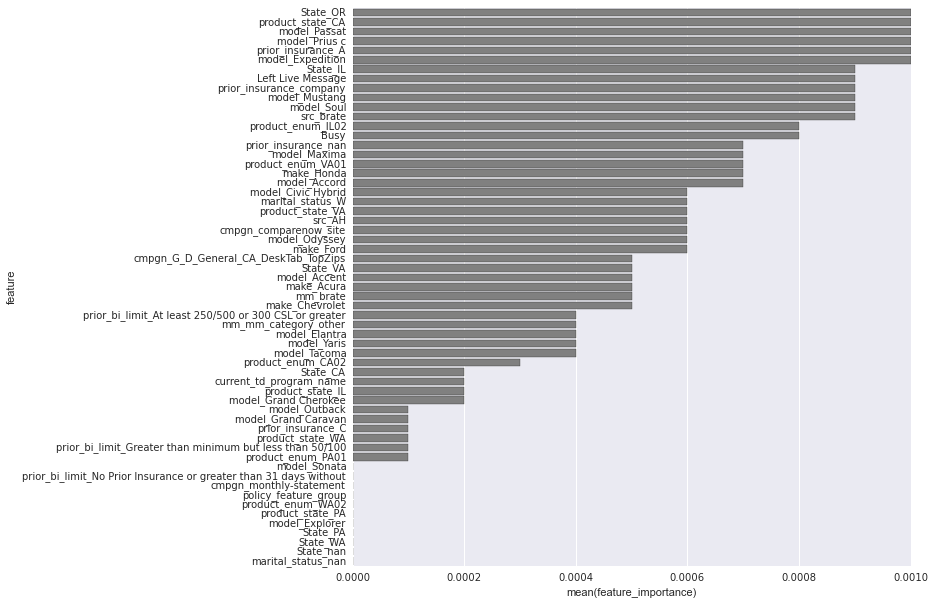

In [1209]:
feature_rank = feature_rank[feature_rank['feature_importance'] <=0.001]
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.123
average esign rate: 0.0525
top decile esign / avg. esign: 2.341

F1 Score: 0.0411
accuracy: 0.9443
precision: 0.2143
recall: 0.0227
confusion matrix:
[[2369   11]
 [ 129    3]]


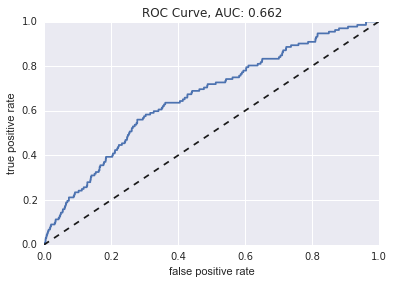

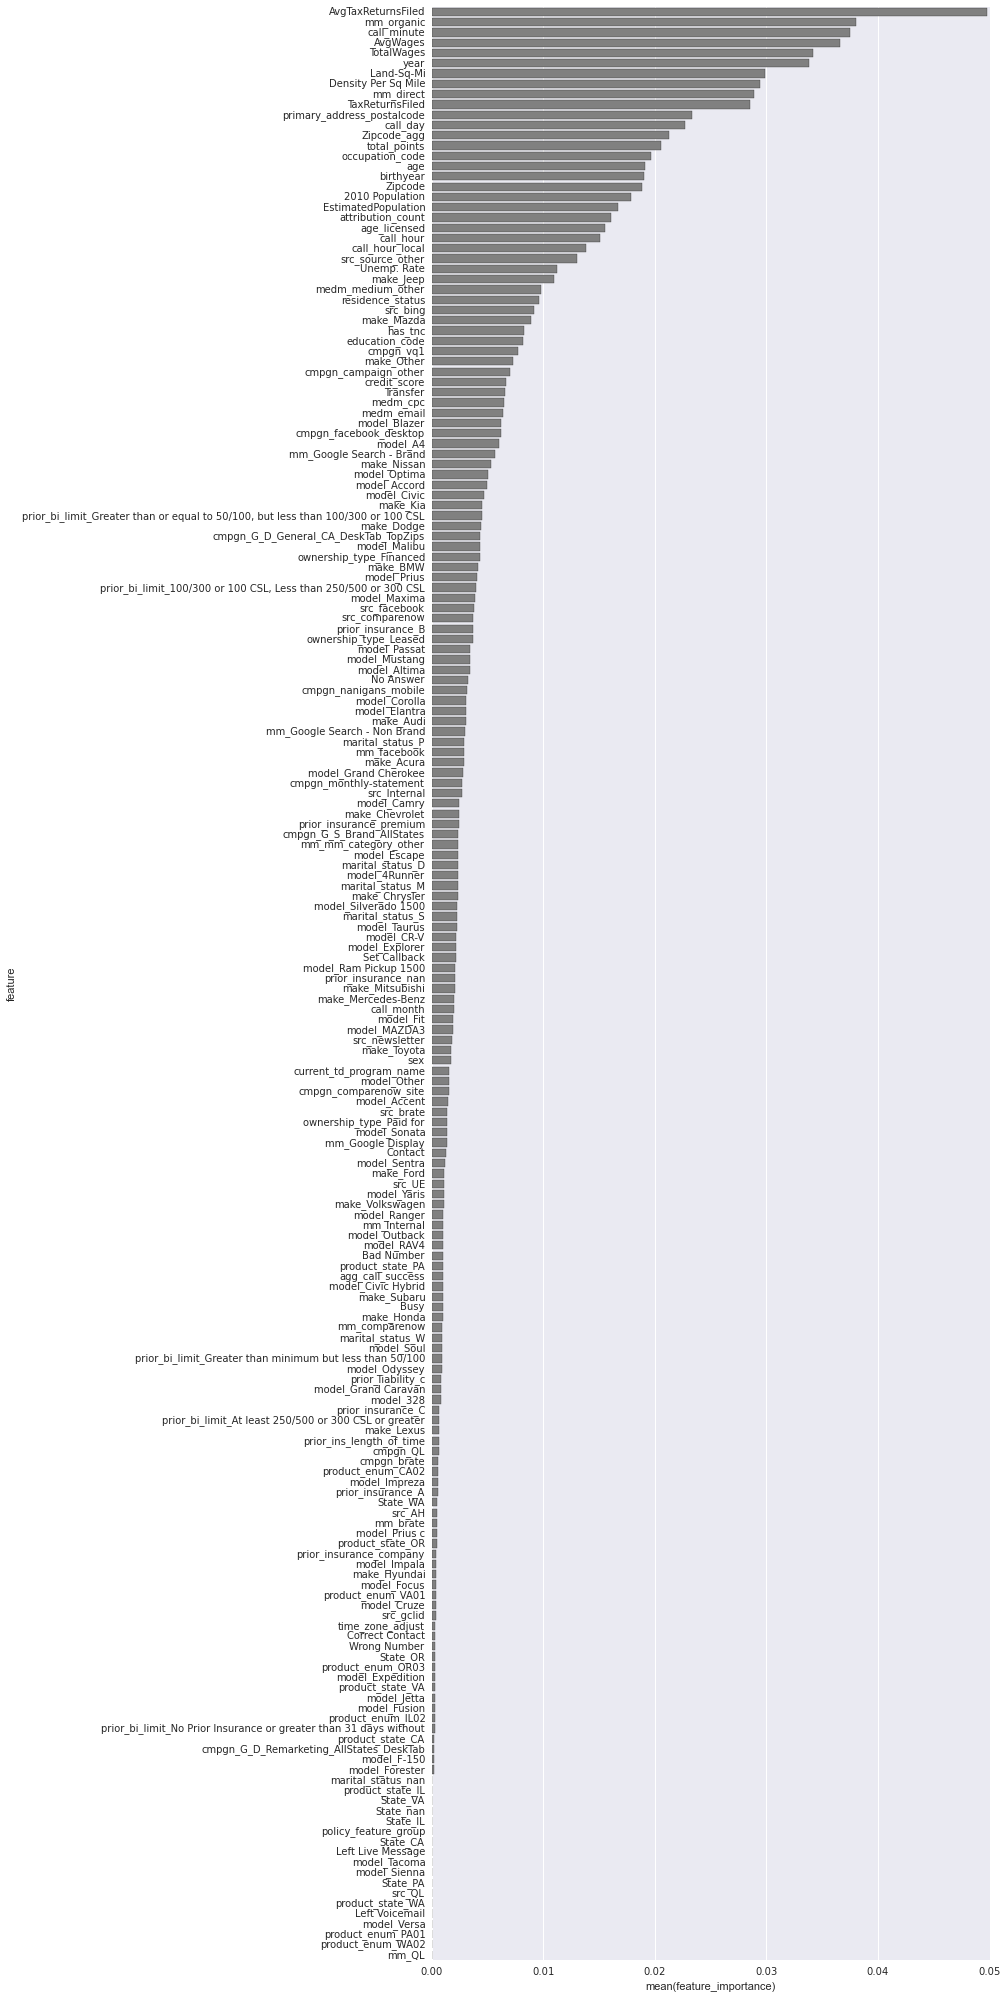

In [1218]:
#best current model 

#GBtrees, Phone unique accounts, all data
model_eval(Xtrain_phone,ytrain_phone, Xtest_phone, ytest_phone,gb)

feature_rank = pd.DataFrame({'feature':Xtrain_phone.columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

import seaborn as sns
plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1151
average esign rate: 0.0525
top decile esign / avg. esign: 2.19

F1 Score: 0.0552
accuracy: 0.9455
precision: 0.3077
recall: 0.0303
confusion matrix:
[[2371    9]
 [ 128    4]]


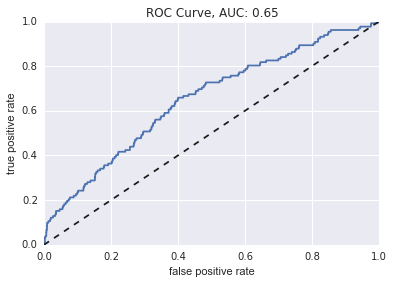

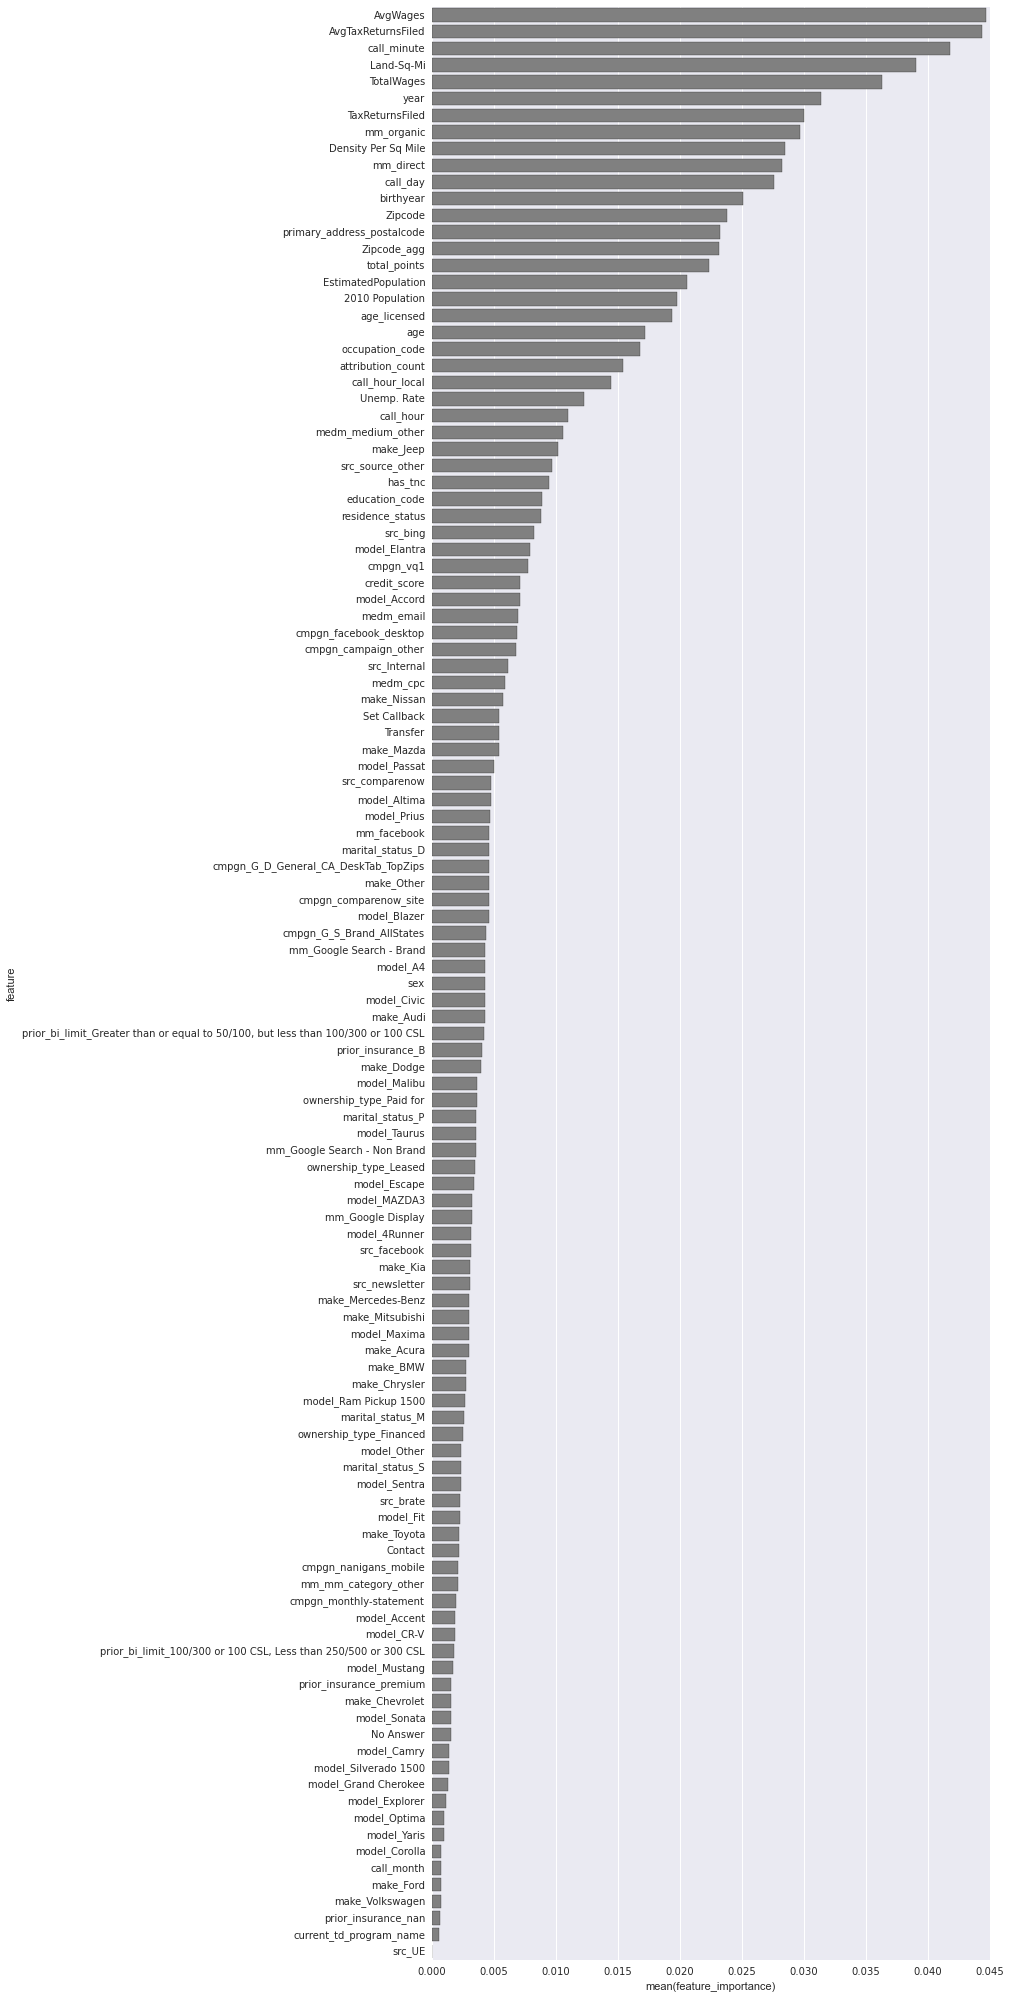

In [1219]:
#feature selection on a feature importance threshhold
#GBtrees, Phone unique accounts, all data
top_features = feature_rank['feature'][feature_rank['feature_importance'] > .001]

model_eval(Xtrain_phone.ix[:,top_features],ytrain_phone, Xtest_phone.ix[:,top_features], ytest_phone,gb)

feature_rank = pd.DataFrame({'feature':Xtrain_phone.ix[:,top_features].columns, 'feature_importance':gb.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

import seaborn as sns
plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

In [1206]:
print Xtrain_phone.shape[1]
print feature_rank.shape[0]

184
134


top decile esign rate: 0.6745
average esign rate: 0.1296
top decile esign / avg. esign: 5.203

F1 Score: 0.5641
accuracy: 0.9071
precision: 0.72
recall: 0.4637
confusion matrix:
[[11598   320]
 [  952   823]]


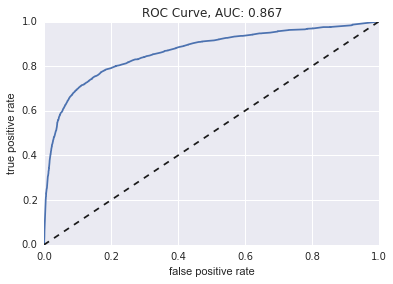

In [916]:
#Random forest, Attribution unique accounts
rf = RandomForestClassifier(n_estimators=300)
model_eval(Xtrain,ytrain, Xtest, ytest, rf )

In [145]:
most_likely = pd.DataFrame({'feature':Xtrain.columns, 'feature_importance':rf.feature_importances_.round(4)}).sort('feature_importance', ascending=False)
most_likely.head(20)

,feature,feature_importance
24,medm_medium_other,0.0458
30,cmpgn_campaign_other,0.0454
36,attribution_count,0.0430
7,mm_direct,0.0381
21,src_source_other,0.0364
10,mm_organic,0.0353
56,AvgTaxReturnsFiled,0.0348
49,Land-Sq-Mi,0.0320
54,Zipcode_agg,0.0295
52,birthyear,0.0294


In [344]:
#random forests most likely to sign up
most_likely = Xtest.join(ytest)
most_likely['predicted_esign'] = rf.predict(Xtest)
most_likely['predicted_prob_esign'] = rf.predict_proba(Xtest)[:,1]
most_likely.sort('predicted_prob_esign',ascending=False).head(15)

,mm_Google Display,mm_Google Search - Brand,mm_Google Search - Non Brand,mm_Internal,mm_QL,mm_brate,mm_comparenow,mm_direct,mm_facebook,mm_mm_category_other,...,Left Live Message,Left Voicemail,No Answer,Set Callback,Transfer,Wrong Number,agg_call_success,esign_boolean,predicted_esign,predicted_prob_esign
account_number,,,,,,,,,,,,,,,,,,,,,
31-121861,0,0,0,1,0,0,0,4,0,0,...,0,0,2,0,0,0,-2,0,1,0.950000
31-117205,0,0,0,0,1,0,0,7,0,0,...,0,0,2,0,0,0,-2,1,1,0.940000
31-113180,0,0,0,1,0,0,0,3,0,0,...,0,0,2,0,0,0,-2,1,1,0.933333
21-025047,0,0,0,1,0,0,0,8,0,0,...,0,0,2,0,0,0,-2,1,1,0.930000
42-025172,0,0,0,1,0,0,0,7,0,0,...,0,0,2,0,0,0,-2,1,1,0.925000
31-109694,0,0,1,2,0,0,0,17,0,1,...,0,0,2,0,0,0,-2,1,1,0.923333
10-003564,0,0,0,1,0,0,0,11,0,0,...,0,0,2,0,0,0,-2,1,1,0.920000
31-117142,0,0,0,1,0,0,0,20,0,0,...,0,0,2,0,0,0,-2,1,1,0.910000
31-130269,0,0,0,1,0,0,0,5,0,0,...,0,0,2,0,0,0,-2,1,1,0.906667


top decile esign rate: 0.4241
average esign rate: 0.1325
top decile esign / avg. esign: 3.2012

F1 Score: 0.2138
accuracy: 0.8689
precision: 0.5203
recall: 0.1345
confusion matrix:
[[11654   225]
 [ 1570   244]]


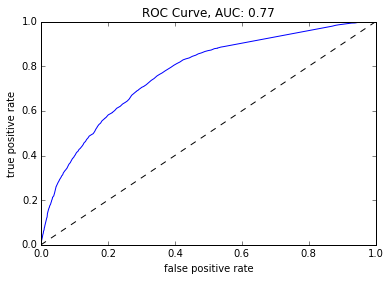

In [348]:
#Random forests, attribution unique accounts, excluding attribution data
rf = RandomForestClassifier(n_estimators=300, max_features='auto')
model_eval(X_exclAttr_train,y_exclAttr_train, X_exclAttr_test, y_exclAttr_test,rf )

top decile esign rate: 0.6168
average esign rate: 0.1298
top decile esign / avg. esign: 4.7501

F1 Score: 0.4861
accuracy: 0.8959
precision: 0.6774
recall: 0.3791
confusion matrix:
[[11594   321]
 [ 1104   674]]


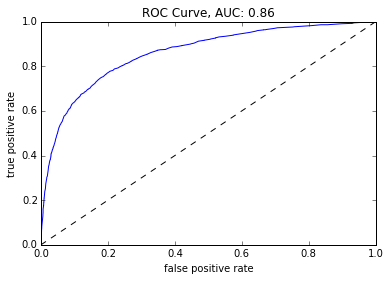

In [350]:
#Random Forests, Attribution unique accounts, excluding phone features
rf = RandomForestClassifier(n_estimators=300, max_features='auto')
model_eval(X_exclPhone_train,y_exclPhone_train, X_exclPhone_test, y_exclPhone_test,rf )

top decile esign rate: 0.1548
average esign rate: 0.0689
top decile esign / avg. esign: 2.2472

F1 Score: 0.0
accuracy: 0.9311
precision: 0.0
recall: 0.0
confusion matrix:
[[2339    0]
 [ 173    0]]


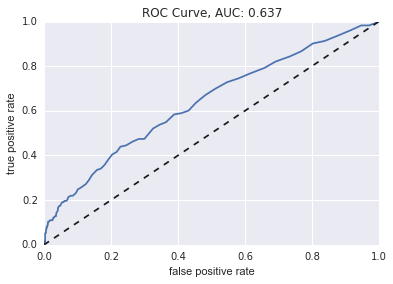

In [1194]:
#Random forest, Phone unique accounts, all data
rf = RandomForestClassifier(n_estimators=300)
model_eval(Xtrain_phone,ytrain_phone, Xtest_phone, ytest_phone, rf )

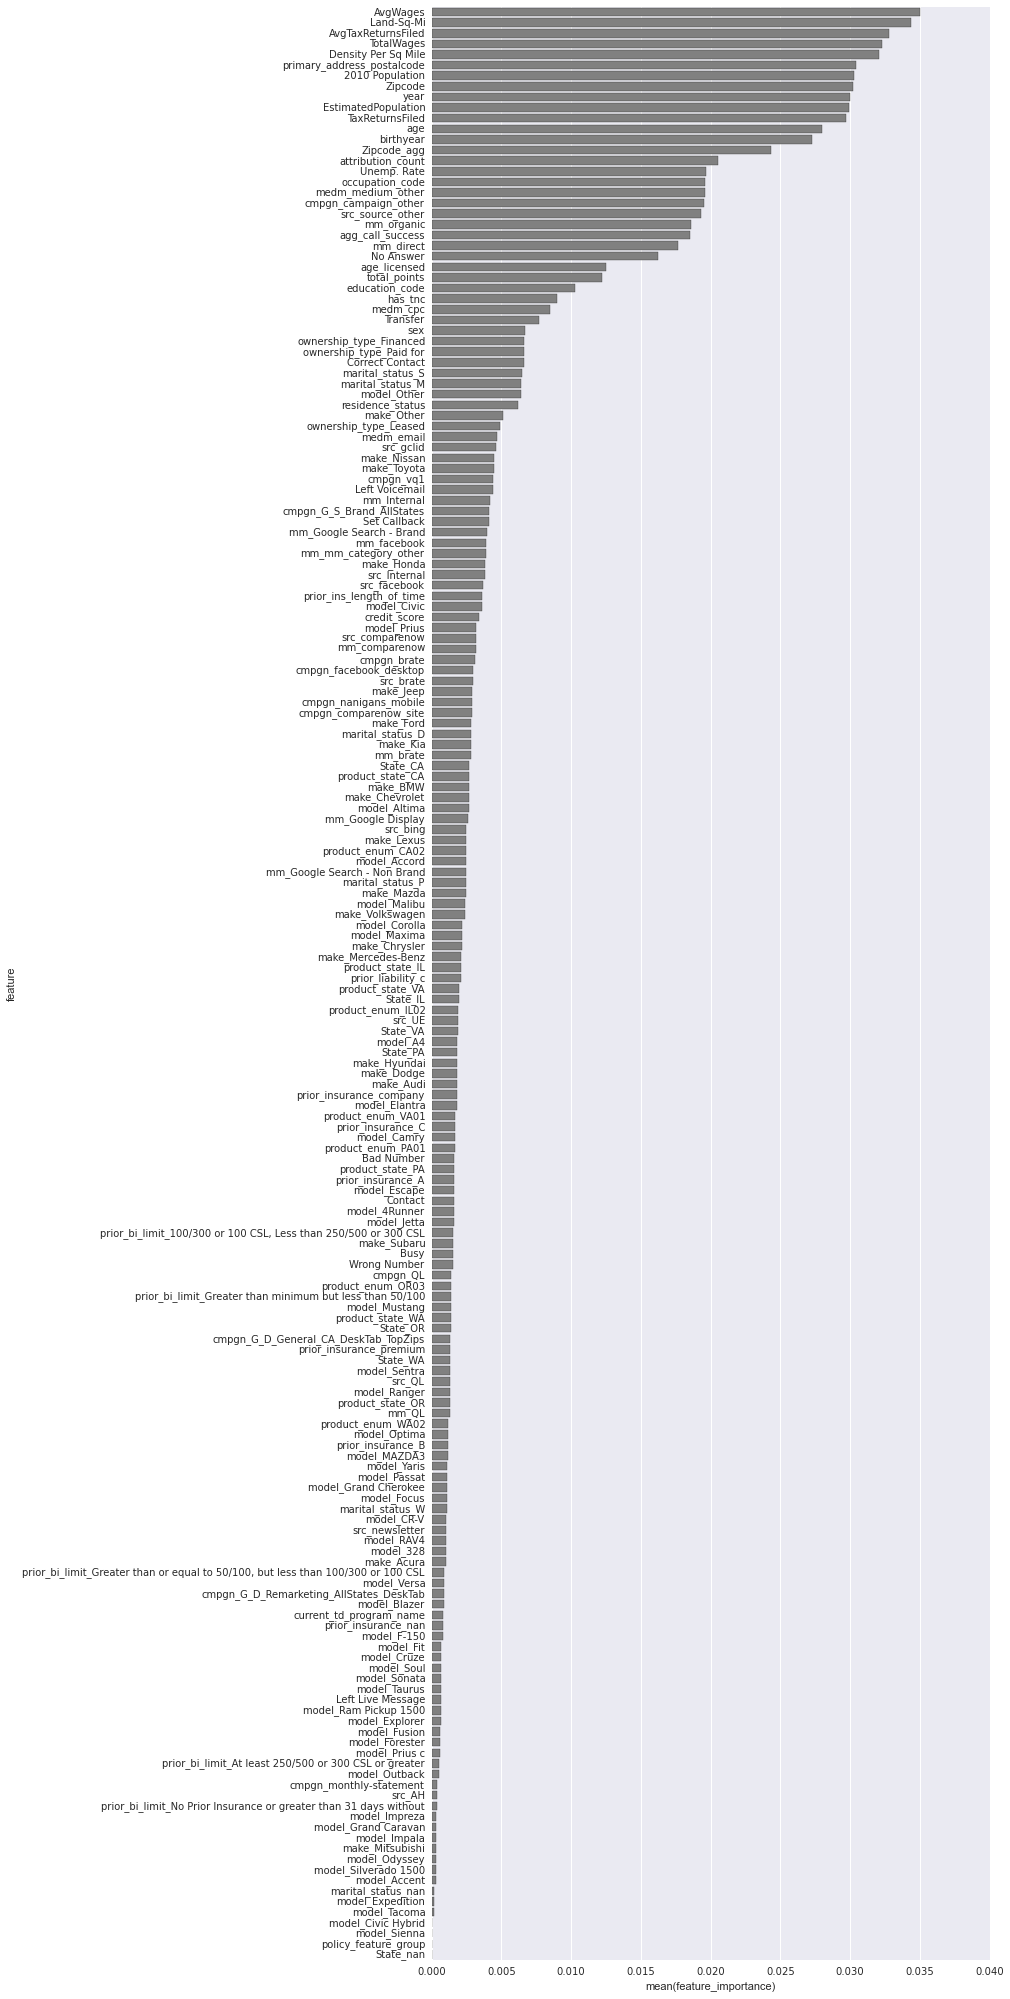

In [528]:
feature_rank = pd.DataFrame({'feature':Xtrain_phone.columns, 'feature_importance':rf.feature_importances_.round(4)})
feature_rank = feature_rank.sort('feature_importance', ascending=False)

import seaborn as sns
plt.figure(figsize=(10,35))
sns.barplot(y=feature_rank['feature'],x=feature_rank['feature_importance'], color='grey')

top decile esign rate: 0.1667
average esign rate: 0.0633
top decile esign / avg. esign: 2.6331

F1 Score: 0.0359
accuracy: 0.9359
precision: 0.375
recall: 0.0189
confusion matrix:
[[2348    5]
 [ 156    3]]


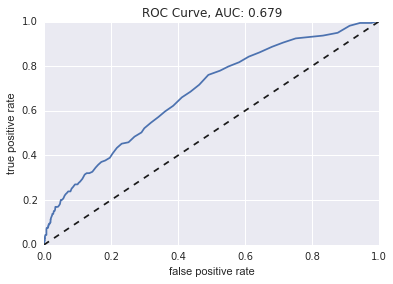

In [537]:
#subset of important features
rf_lim_feature = RandomForestClassifier(n_estimators=300)
model_eval(Xtrain_phone.ix[:,rf.feature_importances_ > 0.002],ytrain_phone, Xtest_phone.ix[:,rf.feature_importances_ > 0.002], ytest_phone, rf_lim_feature )

In [366]:
#RF, Phone unique accounts, most likely to sign up
most_likely = Xtest_phone.join(ytest_phone)
most_likely['predicted_esign'] = rf.predict(Xtest_phone)
most_likely['predicted_prob_esign'] = rf.predict_proba(Xtest_phone)[:,1]
most_likely.sort('predicted_prob_esign',ascending=False).head(15)

,Bad Number,Busy,Contact,Correct Contact,Left Live Message,Left Voicemail,No Answer,Set Callback,Transfer,Wrong Number,...,cmpgn_campaign_other,cmpgn_comparenow_site,cmpgn_facebook_desktop,cmpgn_monthly-statement,cmpgn_nanigans_mobile,cmpgn_vq1,attribution_count,esign_boolean,predicted_esign,predicted_prob_esign
account_number,,,,,,,,,,,,,,,,,,,,,
21-028168,0,0,0,1,0,0,0,0,0,0,...,22,0,0,0,0,0,22,0,1,0.610000
31-131736,0,0,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,2,0,1,0.606667
31-128601,1,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,8,1,0,0.466667
31-126812,0,0,0,1,0,0,3,0,0,0,...,8,0,0,0,0,0,8,1,0,0.440000
31-130729,0,0,0,0,0,0,0,0,0,0,...,106,0,0,0,0,0,106,0,0,0.433333
21-027962,0,0,0,0,0,0,1,1,0,0,...,13,0,0,0,0,0,13,0,0,0.423333
31-132801,0,0,0,0,0,0,2,0,0,0,...,9,0,0,0,0,0,9,1,0,0.406667
02-002804,0,0,0,0,0,0,1,0,0,0,...,94,0,0,0,0,0,94,0,0,0.400000
31-130966,0,0,0,0,0,0,1,0,0,0,...,10,0,0,0,0,0,10,1,0,0.396667


top decile esign rate: 0.1389
average esign rate: 0.0649
top decile esign / avg. esign: 2.1404

F1 Score: 0.0118
accuracy: 0.9331
precision: 0.1429
recall: 0.0061
confusion matrix:
[[2343    6]
 [ 162    1]]


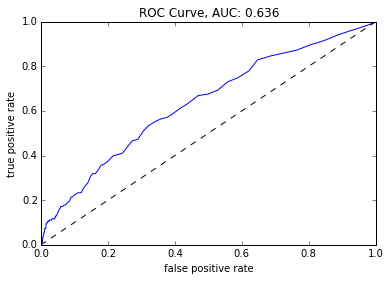

In [367]:
#Random forest, Phone unique accounts, exclude attribution data
rf = RandomForestClassifier(n_estimators=300)
model_eval(X_exclAttr_train_phone,y_exclAttr_train_phone, X_exclAttr_test_phone, y_exclAttr_test_phone, rf )

top decile esign rate: 0.1389
average esign rate: 0.0649
top decile esign / avg. esign: 2.1404

F1 Score: 0.012
accuracy: 0.9343
precision: 0.25
recall: 0.0061
confusion matrix:
[[2346    3]
 [ 162    1]]


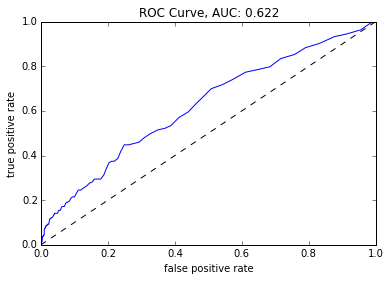

In [368]:
#Random forest, Phone unique accounts, exclude phone data
rf = RandomForestClassifier(n_estimators=300)
model_eval(X_exclPhone_train_phone,y_exclPhone_train_phone, X_exclPhone_test_phone, y_exclPhone_test_phone, rf )

top decile esign rate: 0.1627
average esign rate: 0.0633
top decile esign / avg. esign: 2.5704

F1 Score: 0.1705
accuracy: 0.8993
precision: 0.1781
recall: 0.1635
confusion matrix:
[[2233  120]
 [ 133   26]]


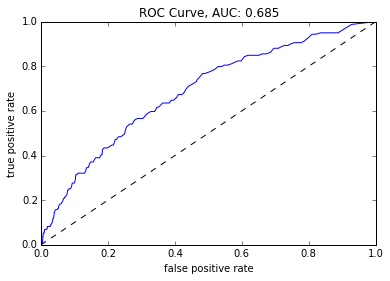

In [369]:
#Random forest, Phone unique accounts, all data, class imbalance weighted
rf = RandomForestClassifier(n_estimators=300,class_weight={0:2e-8,1:1})
model_eval(Xtrain_phone,ytrain_phone, Xtest_phone, ytest_phone, rf )

In [ ]:
#Random Forest grid search
"""
parameters = {'n_estimators':[100, 300, 600]}
gs = GridSearchCV(rf, parameters, cv=3)
gs.fit(Xtrain_phone, ytrain_phone)
print gs.best_params_
print score(ytest_phone, gs.predict(Xtest_phone))
"""

top decile esign rate: 0.7015
average esign rate: 0.1324
top decile esign / avg. esign: 5.2979

F1 Score: 0.5846
accuracy: 0.9068
precision: 0.7133
recall: 0.4953
confusion matrix:
[[11519   361]
 [  915   898]]
top decile esign rate: 0.446
average esign rate: 0.1325
top decile esign / avg. esign: 3.3665

F1 Score: 0.235
accuracy: 0.8735
precision: 0.5911
recall: 0.1466
confusion matrix:
[[11695   184]
 [ 1548   266]]
top decile esign rate: 0.6438
average esign rate: 0.1298
top decile esign / avg. esign: 4.9581

F1 Score: 0.5153
accuracy: 0.8994
precision: 0.6886
recall: 0.4117
confusion matrix:
[[11584   331]
 [ 1046   732]]


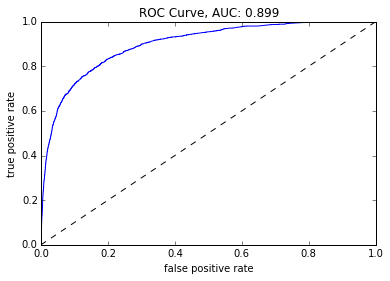

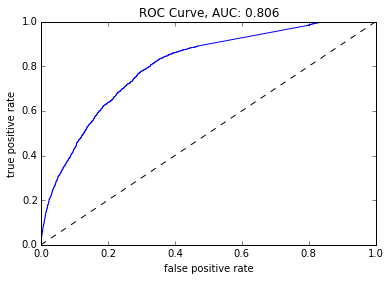

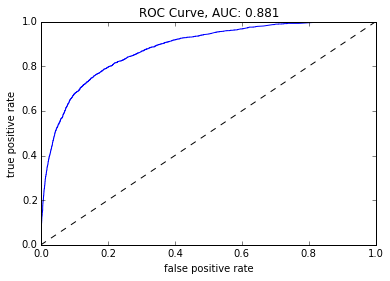

In [358]:
#zip code average wages, tax filings, zipcode aggregate increass F1 score by 0.004 (.5208 ->.5248)
#zip code population density, sq. miles, (.5248 -> .5315)
#attribution categories. mm_category, source, medium, campaign (.5315 -> .5837)
#removed categorical features (.5837 -> .5778)
#removed leakage from attribution with activity after signup (.5778 -> 0.3574)

#removed leakage from attribution with activity after signup (0.89 -> 0.818)
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
n_estimators = 230,
learning_rate = 0.07,
max_depth = 5,
subsample = 1,
max_features = None)

#GBtrees, Attribution unique accounts, all data
model_eval(Xtrain, ytrain, Xtest, ytest,gb )

#GBtrees, Attribution unique accounts, excluding attribution data
model_eval(X_exclAttr_train,y_exclAttr_train, X_exclAttr_test, y_exclAttr_test, gb )

#gbtrees, Attribution unique accounts, excluding phone data
model_eval(X_exclPhone_train,y_exclPhone_train, X_exclPhone_test, y_exclPhone_test, gb )

top decile esign rate: 0.2143
average esign rate: 0.0633
top decile esign / avg. esign: 3.3854

F1 Score: 0.0865
accuracy: 0.9327
precision: 0.3077
recall: 0.0503
confusion matrix:
[[2335   18]
 [ 151    8]]


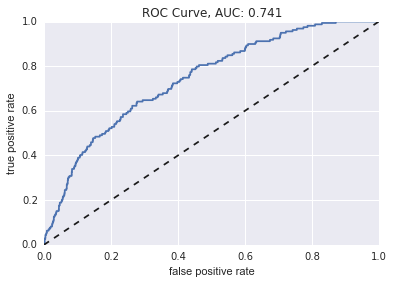

In [583]:
#GBtrees, Phone unique accounts, all data
model_eval(Xtrain_phone,ytrain_phone, Xtest_phone, ytest_phone,gb)

In [371]:
most_likely = pd.DataFrame({'feature':Xtrain.columns, 'feature_importance':gb.feature_importances_.round(3)}).sort('feature_importance', ascending=False)
most_likely.head(20)

,feature,feature_importance
29,cmpgn_brate,0.063
30,cmpgn_campaign_other,0.054
24,medm_medium_other,0.050
21,src_source_other,0.050
23,medm_email,0.044
80,product_state_OR,0.044
83,product_state_WA,0.036
27,cmpgn_G_S_Brand_AllStates,0.031
28,cmpgn_QL,0.030
20,src_newsletter,0.027


In [372]:
#GB Tree, phone level accounts,  most likely to sign up
temp = gb.predict_proba(Xtest_phone)[:,1]

most_likely = Xtest_phone.copy()
most_likely['esign_boolen'] = ytest_phone.values
most_likely = most_likely.iloc[np.argsort(temp)[::-1]]
most_likely['probability'] = np.sort(temp)[::-1]
most_likely.head(10)

,Bad Number,Busy,Contact,Correct Contact,Left Live Message,Left Voicemail,No Answer,Set Callback,Transfer,Wrong Number,...,cmpgn_brate,cmpgn_campaign_other,cmpgn_comparenow_site,cmpgn_facebook_desktop,cmpgn_monthly-statement,cmpgn_nanigans_mobile,cmpgn_vq1,attribution_count,esign_boolen,probability
account_number,,,,,,,,,,,,,,,,,,,,,
21-027962,0,0,0,0,0,0,1,1,0,0,...,0,13,0,0,0,0,0,13,0,0.901763
31-123452,0,0,1,0,0,0,1,0,0,0,...,0,5,0,0,0,0,1,6,0,0.880904
21-027094,0,0,0,0,0,0,1,0,1,0,...,0,14,1,0,0,0,0,15,0,0.858538
21-028168,0,0,0,1,0,0,0,0,0,0,...,0,22,0,0,0,0,0,22,0,0.857984
02-000519,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0.838615
10-002576,0,0,0,0,0,0,1,0,1,0,...,0,33,1,0,0,0,0,34,0,0.834380
31-124207,0,0,0,0,0,0,1,0,0,0,...,1,2,0,0,0,0,3,6,1,0.727454
31-124867,0,0,0,0,0,0,0,2,0,0,...,0,3,0,0,0,0,1,4,0,0.727021
31-122775,0,0,0,0,0,1,2,0,0,0,...,0,2,0,0,0,0,0,2,1,0.723902


top decile esign rate: 0.1627
average esign rate: 0.0649
top decile esign / avg. esign: 2.5074

F1 Score: 0.0761
accuracy: 0.9323
precision: 0.3333
recall: 0.0429
confusion matrix:
[[2335   14]
 [ 156    7]]


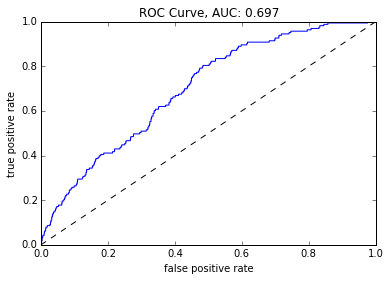

In [373]:
#GBtrees, Phone unique accounts, excluding attribution features
model_eval(X_exclAttr_train_phone,y_exclAttr_train_phone, X_exclAttr_test_phone, y_exclAttr_test_phone,gb)

top decile esign rate: 0.1627
average esign rate: 0.0649
top decile esign / avg. esign: 2.5074

F1 Score: 0.0442
accuracy: 0.9311
precision: 0.2222
recall: 0.0245
confusion matrix:
[[2335   14]
 [ 159    4]]


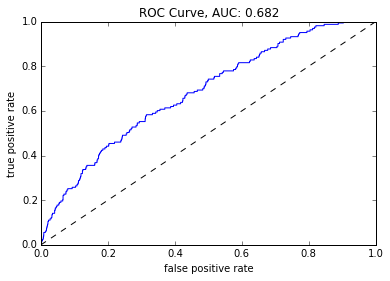

In [374]:
#GBtrees, Phone unique accounts, excluding phone features
model_eval(X_exclPhone_train_phone,y_exclPhone_train_phone, X_exclPhone_test_phone, y_exclPhone_test_phone,gb)

top decile esign rate: 0.1627
average esign rate: 0.0689
top decile esign / avg. esign: 2.3624

F1 Score: 0.044
accuracy: 0.9307
precision: 0.4444
recall: 0.0231
confusion matrix:
[[2334    5]
 [ 169    4]]


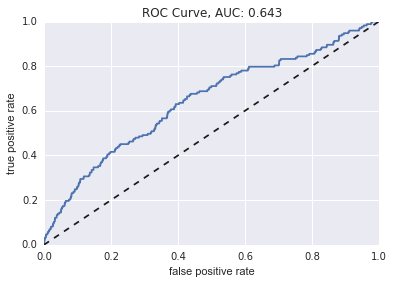

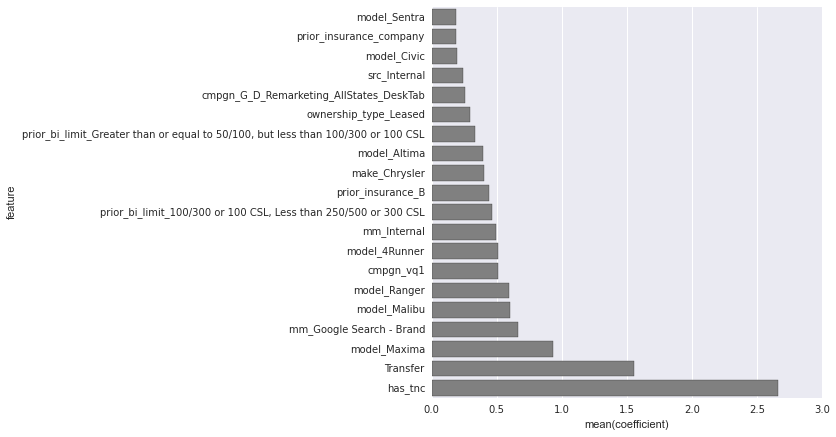

In [1195]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1')
#best current model
#GBtrees, Phone unique accounts, all data
model_eval(Xtrain_phone,ytrain_phone, Xtest_phone, ytest_phone,lr)


pd.options.display.float_format = '{:,.3f}'.format
feature_coef = pd.DataFrame({'feature':Xtrain_phone.columns,'coefficient': lr.coef_[0]})
feature_coef = feature_coef.sort('coefficient')
plt.figure(figsize=(7,7))
sns.barplot(y=feature_coef['feature'][-20:],x=feature_coef['coefficient'][-20:], color='grey')

In [962]:
#SVM
"""
parameters = [{'C': [1, 10, 100], 'kernel': ['linear']}]
gs = GridSearchCV(svc, parameters, cv=3)
gs.fit(Xtrain_phone, ytrain_phone)
print gs.best_params_
print score(ytest_phone, gs.predict(Xtest_phone))
"""

"\nparameters = [{'C': [1, 10, 100], 'kernel': ['linear']}]\ngs = GridSearchCV(svc, parameters, cv=3)\ngs.fit(Xtrain_phone, ytrain_phone)\nprint gs.best_params_\nprint score(ytest_phone, gs.predict(Xtest_phone))\n"

In [ ]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(Xtrain_phone, ytrain_phone.astype(float))
score(svc_model.predict(Xtest_phone), ytest_phone)

In [ ]:
"""
clf = xgb.XGBClassifier(n_estimators=100,
                        nthread=-1,
                        max_depth=5,
                        learning_rate=0.1,
                        silent=True,
                        subsample=1,
                        colsample_bytree=0.8)
parameters = {'n_estimators':[170, 200, 230],'nthread':[-1],'max_depth':[5, 7], 'learning_rate':[0.07], 'subsample':[1], 'colsample_bytree':[0.8] }
gs = GridSearchCV(clf, parameters, cv=3)

gs.fit(Xtrain, ytrain)
print gs.best_params_
print score(ytest, gs.predict(Xtest))
""";

In [ ]:
"""#xgb without cross validation
gb_model = xgb.XGBClassifier(n_estimators= 230,
                        nthread=-1,
                        max_depth=5,
                        learning_rate=0.07,
                        silent=True,
                        subsample=1,
                        colsample_bytree=0.8)
gb_model.fit(Xtrain, ytrain)
score(ytest, gb_model.predict(Xtest))
""";

In [ ]:
#ranks features from most important
feature_importance = np.argsort(gb.feature_importances_)[::-1]
x_col = X.columns
#feature, % of total
[[x_col[rank], round(sorted(gb.feature_importances_)[::-1][idx],3)] for idx, rank in enumerate(feature_importance)]

In [ ]:
"""
from sklearn.grid_search import RandomizedSearchCV
from operator import itemgetter
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

params = {'n_estimators': [70,100,150,200,300,500],
           'learning_rate':[0.05,0.08,0.1,0.125,0.15,0.2],
          'max_depth': [2,3,4],
          'subsample':[0.8,0.9,1],
          'max_features':[None,3,5,8]}
n_iter_search = 20
rcv = RandomizedSearchCV(gb, param_distributions=params, n_iter=n_iter_search)

start = time.time()
rcv.fit(Xtrain, ytrain)
print("RandomizedSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))
report(rcv.grid_scores_)
""";

In [ ]:
### End formatting tables for prediction ###

### Begin exploratory summary statistics ###

In [ ]:
drivers['age_licensed'].value_counts().sort_index().plot(kind='bar', xlim=[1,10])

In [ ]:
phone['call_result'].value_counts()

## phone data
overall: predict conversion rates based on phone data

1. normalize for account time zone
2. understand the call_result category. are the categories accurate, wrong number vs no answer. when to leave voicemail
3. create call related features to predict signup
    hour of day (normalized)
    day of month
    month in year
    number of calls before signup by call_result
    
4. cluster people who immediately sign up (no phone records), sign up after phone calls, etc.



In [982]:
#accounts overlap
phone_out2['account_number'].isin(drivers_out2['account_number']).value_counts()

True     25110
False     1738
dtype: int64

In [1101]:
#confirms that control group didn't receive calls
phone.set_index('account_number').join(phone_experiment).groupby('Cell').count()['call_result']

Cell
Control 1        3
Modeled      23141
Name: call_result, dtype: int64

In [1078]:
attrib_experiment = attribution3.join(phone_experiment, how='left').join(converted_out, how='left')
attrib_experiment['esign_boolean'] = pd.notnull(attrib_experiment['esign_datetime'])*1

#conditioned on accounts present in 2 months attribution activity between Aug-2015 to Oct-2015
attrib_experiment.groupby('Cell').mean()['esign_boolean']


Cell
Control 1   0.059
Modeled     0.071
Name: esign_boolean, dtype: float64

In [1082]:
#assumes identical expected values, and underlying population has same variance
#phone team calls all accounts with a phone number that haven't signed up
from scipy.stats import ttest_ind
from scipy.stats import chisquare
a = attrib_experiment[attrib_experiment['Cell'] =='Modeled']['esign_boolean'].values
b = attrib_experiment[attrib_experiment['Cell'] =='Control 1']['esign_boolean'].values

print 'two-sided independent t-test. Not appropriate, assumes a normal distribution when percentages are bound by 0-1'
print ttest_ind(a, b)
print ''
print 'The chi square test tests the null hypothesis that the categorical data has the given frequencies.'
test_pos = sum(b)
test_all = len(b)
expected_pos = len(b) * (sum(a)/len(a))

print chisquare([test_pos, test_all - test_pos],[expected_pos, test_all - expected_pos])

two-sided independent t-test. Not appropriate, assumes a normal distribution when percentages are bound by 0-1
Ttest_indResult(statistic=2.0721173004747304, pvalue=0.03826360235474735)

The chi square test tests the null hypothesis that the categorical data has the given frequencies.
Power_divergenceResult(statistic=4.6175731123686976, pvalue=0.031645982621767994)


In [ ]:
#all attributions
delta_days_esign = (attrib_converted3.groupby('weblog_delta_days').sum()['esign_bool'] / attrib_converted3.groupby('weblog_delta_days').count()['esign_bool'])
delta_days_esign = delta_days_esign.reset_index()
#alive attributions
attrib_alive = attrib_converted3[attrib_converted3['live_attribution']]
delta_days_esign_alive = (attrib_alive.groupby('weblog_delta_days').sum()['esign_bool'] / attrib_alive.groupby('weblog_delta_days').count()['esign_bool'])
delta_days_esign_alive = delta_days_esign_alive.reset_index()

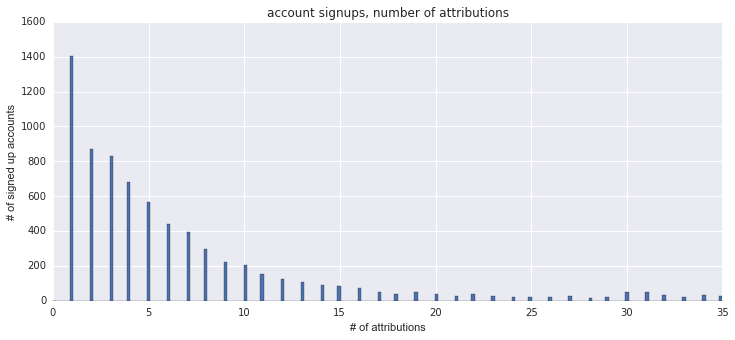

In [1019]:
attribution.merge(converted, how='right').groupby('account_number').count()['esign_datetime'].hist(bins=200,range=[0, 35], figsize=(12,5))
plt.title('account signups, number of attributions')
plt.xlabel("# of attributions")
plt.ylabel("# of signed up accounts")

In [1035]:
random_account = np.random.choice(phone_out2['account_number'].unique()) 
random_success_account = np.random.choice(phone_out2[phone_out2['esign_bool'] == True]['account_number'].unique()) 
random_fail_account = np.random.choice(phone_out2[phone_out2['esign_bool'] == True]['account_number'].unique()) 
phone_out2[phone_out2['account_number'] == random_success_account]

,call_time,call_result,account_number,hour,year,month,minute,call_success,esign_datetime,esign_bool
1038,2015-09-28 09:41:00,No Answer,10-004901,9,2015,9,41,False,2015-09-27 17:57:47,True
1039,2015-09-28 13:58:00,No Answer,10-004901,13,2015,9,58,False,2015-09-27 17:57:47,True
1040,2015-10-01 11:01:00,No Answer,10-004901,11,2015,10,1,False,2015-09-27 17:57:47,True


In [1036]:
#compare call time relative to esign date
phone_out2[phone_out2['account_number'] ==random_success_account]['call_time'] - phone_out2[phone_out2['account_number'] ==random_success_account]['esign_datetime']

1038   0 days 15:43:13
1039   0 days 20:00:13
1040   3 days 17:03:13
dtype: timedelta64[ns]

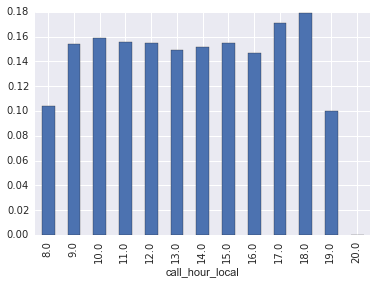

In [1133]:
#probability of successfully reaching someone by local hour you call them
phone_byhour = phone_out2.copy()
phone_byhour['call_success'] = phone_out2['call_result'].isin(success_contact)
phone_byhour.groupby('call_hour_local').mean()['call_success'].plot(kind='bar')

In [1108]:
phone_out2.groupby(['call_result','hour'])['esign_bool'].apply(lambda x: x.sum()/ x.count()).unstack().transpose()

call_result,Bad Number,Busy,Contact,Correct Contact,Left Live Message,Left Voicemail,No Answer,Set Callback,Transfer,Wrong Number
hour,,,,,,,,,,
8,0.042,0.000,0.000,0.048,nan,0.026,0.048,0.059,0.167,0.143
9,0.024,0.000,0.037,0.033,0.000,0.000,0.061,0.070,0.257,0.026
10,0.046,0.067,0.011,0.038,0.000,0.059,0.056,0.094,0.184,0.024
11,0.044,0.000,0.000,0.043,nan,0.000,0.050,0.050,0.178,0.000
12,0.016,0.100,0.064,0.026,1.000,0.158,0.049,0.075,0.300,0.000
13,0.000,0.071,0.030,0.050,0.000,0.104,0.046,0.061,0.250,0.111
14,0.039,0.067,0.011,0.032,0.000,0.102,0.055,0.048,0.059,0.043
15,0.000,0.086,0.029,0.045,nan,0.074,0.048,0.038,0.205,0.021
16,0.019,0.059,0.042,0.053,0.000,0.000,0.037,0.079,0.000,0.000


In [1039]:
phone_temp = pd.merge(phone, converted, how='left')
phone_temp['call_time'] = pd.to_datetime(phone_temp['call_time'])
phone_temp['esign_datetime'] = pd.to_datetime(phone_temp['esign_datetime'])

In [1040]:
pd.notnull(phone_temp['esign_datetime']).sum()

1471

In [1041]:
pd.notnull(phone_temp['esign_datetime']).count()

26848

In [1042]:
pd.merge(phone_out2.groupby('account_number').sum().reset_index(), converted, how='left').head(10)

,account_number,hour,year,month,minute,call_success,esign_bool,esign_datetime
0,02-000512,45,8060,36,63,0.000,0.000,NaN
1,02-000514,31,6045,27,117,0.000,0.000,NaN
2,02-000515,30,6045,27,102,0.000,0.000,NaN
3,02-000517,10,2015,9,53,1.000,0.000,NaN
4,02-000519,19,4030,18,84,0.000,2.000,2015-10-06 14:59:43
5,02-000520,10,2015,9,29,0.000,0.000,NaN
6,02-000521,33,6045,27,81,0.000,0.000,NaN
7,02-000523,24,4030,18,101,1.000,0.000,NaN
8,02-000524,67,10075,45,126,0.000,0.000,NaN
9,02-000527,32,6045,27,24,0.000,0.000,NaN
